# setup

In [1]:
tables = ['volc.csv']
mydrive= 'E:/mydoc/git/trade/analyics/'
# """
tables = ['volcvn.csv','volcvt.csv','volcva.csv']
from google.colab import drive
drive.mount('/content/drive')
mydrive='/content/drive/MyDrive/volrt/'
# Requirements:
%pip install git+https://github.com/jerronl/rtdl.git

#"""

appname='Xcf_'
duration = 5
duration = 6
batch_size=128
bad_value=-99999
vars_h, cat_names, task_types,ys,mergedays,vars_c,= (
    ['date', 'diff', 'spot'],
    [],['regression','multiclass'],
    {5:[['close', 'hi', 'lo',],[ 'pmcat',]],
     6:[['dtm','level','slope','curve',
         'dtm1','level1','slope1','curve1',
         'dtm2','level2','slope2','curve2',
         'dtm3','level3','slope3','curve3'],[]],
    },
    duration in [5],
    {5:[],6:['Horizon','spot']},
)
import numpy as np

vars_h+=list(np.concatenate([ ys[d][0] for d in ys]))
dep_vars=ys[duration]
vars_c=vars_c[duration]

ignore_load_zero=ignore_load_error=y_std=y_mean=X=y=task_type=loss_fn=my_model=jobsize=offset=start_epoch=optimizer = None

import warnings
warnings.filterwarnings('ignore')
from typing import Any, Dict
import rtdl
import scipy.special
import sklearn.datasets
import sklearn.metrics
import sklearn.model_selection
import sklearn.preprocessing
import torch
import torch.nn as nn
import torch.nn.functional as F
import rtdl.zero as zero
import matplotlib.pyplot as plt,os
%matplotlib inline
from typing import Optional
from torch import Tensor
import torch.nn as nn
import math
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder
from pickle import dump, load
import seaborn as sns
import random
from datetime import datetime

# !pip install cloud-tpu-client==0.10 torch==1.13.0 https://storage.googleapis.com/tpu-pytorch/wheels/cuda/112/torch_xla-1.13-cp38-cp38-linux_x86_64.whl --force-reinstall
# import torch_xla
# import torch_xla.core.xla_model as xm
# device = xm.xla_device()

device = torch.device('cuda')
zero.improve_reproducibility(seed=1234567)


Mounted at /content/drive
  Cloning https://github.com/jerronl/rtdl.git to /tmp/pip-req-build-6b145b8e
  Running command git clone --filter=blob:none --quiet https://github.com/jerronl/rtdl.git /tmp/pip-req-build-6b145b8e
  Resolved https://github.com/jerronl/rtdl.git to commit f98ce61e5574c18e249a21e417e208f4832de808
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for rtdl: filename=rtdl-0.0.14.dev0-py3-none-any.whl size=77961 sha256=9c7e55331012827cc4376386bbcaab21298f43fe078b04071d2dc5ae96b9611d
  Stored in directory: /tmp/pip-ephem-wheel-cache-emwd1iqe/wheels/8d/92/7b/32aaeaca71d3de56c377bd2561972e24497e709ff9f9d967cc
Successfully built rtdl


1234567

# model

In [6]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_len=5000, position=None):
        """
        Inputs
            d_model - Hidden dimensionality of the input.
            max_len - Maximum length of a sequence to expect.
        """
        super().__init__()

        # Create matrix of [SeqLen, HiddenDim] representing the positional encoding for max_len inputs
        pe = torch.zeros(max_len, d_model)
        if position is None:
            position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)

        # register_buffer => Tensor which is not a parameter, but should be part of the modules state.
        # Used for tensors that need to be on the same device as the module.
        # persistent=False tells PyTorch to not add the buffer to the state dict (e.g. when we save the model)
        self.register_buffer('pe', pe, persistent=False)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return x
class PETrans(nn.Module):

    def __init__(self, duration, d_model,n_num_features,cat_cardinalities,d_out,x2):
        """
        Inputs
            d_model - Hidden dimensionality of the input.
            max_len - Maximum length of a sequence to expect.
        """
        print("PETrans",duration, d_model,n_num_features,cat_cardinalities,d_out,x2)
        super().__init__()
        # Input dim -> Model dim
        self.input_net = nn.Sequential(
            nn.Linear(duration, d_model*2), # self.hparams.input_dim, self.hparams.model_dim)
            nn.Dropout(0.1), #self.hparams.input_dropout),
            nn.GELU(), # self.hparams.input_dim, self.hparams.model_dim)
            nn.Linear(d_model*2, d_model), # self.hparams.input_dim, self.hparams.model_dim)
        )
        # Positional encoding for sequences
        self.positional_encoding = PositionalEncoding(d_model=d_model)
        self.unf=nn.Flatten(1,2)
        self.ftt= rtdl.FTTransformer.make_default(
            n_num_features=int(n_num_features/duration*d_model+x2),
            cat_cardinalities=cat_cardinalities,
            d_out=d_out,
            )

    def forward(self, x_num: Optional[Tensor], x_cat: Optional[Tensor], x2: Optional[Tensor]) -> Tensor:
        x = self.input_net(x_num)
        x = self.positional_encoding(x)
        x = self.unf(x)
        x = torch.cat((x, x2), 1)
        x = self.ftt(x, x_cat)
        return x

    def make_default_optimizer(self) -> torch.optim.AdamW:
        """Make the optimizer for the default FT-Transformer."""
        return self.ftt.make_default_optimizer()

def apply_model(model, x_num, x_cat=None, x2=None):
    return model(x_num, x_cat, x2)

@torch.no_grad()
def evaluate(mload=None,part='val'):
    model=mload or my_model
    model.eval()
    prediction = []
    for batch in zero.iter_batches(X[part], batch_size):
        prediction.append(apply_model(model,
                                      x_cat=batch[0] if len(cat_names)>0 else None,
                                      x_num=batch[1],x2=batch[2]))
    prediction = torch.cat(prediction)
    target = y[part]
    if task_type == 'binclass':
      prediction = np.round(scipy.special.expit(prediction))
      score = sklearn.metrics.accuracy_score(target, prediction)
    elif task_type == 'multiclass':
      prediction = prediction.argmax(1)
      score = (target.reshape(-1)!=prediction).sum()/len(prediction)
    else:
      assert task_type == 'regression'
      score =mse_loss_with_nans(prediction, target, ) ** 0.5

    return score,target, prediction

@torch.no_grad()
def validate(mload=None):
  score,target, prediction = evaluate(mload,'test')
  print(jobname,f'{score:.4f}')
  if len(dep_var)<2:
    target, prediction =target.cpu().numpy().reshape(-1), prediction.cpu().numpy().reshape(-1)
    sns.jointplot(x=target , y=prediction,kind="kde",fill=True,rug=True)
  else:
    target, prediction = target.squeeze(1).cpu().numpy(), prediction.squeeze(1).cpu().numpy()
    sns.set(style="whitegrid")
    figs=min(len(dep_var),4)
    figure, axes = plt.subplots(math.ceil(len(dep_var)/figs), figs, figsize=(16,16))
    for i,name in enumerate(dep_var):
        axs=axes.flat[i] if figs>1 else axes
        sns.regplot(ax=axs, x=target[:,i] , y=prediction[:,i],
                  scatter_kws = {'color': 'purple', 'alpha': 0.3},
                  line_kws = {'color': '#CCCC00', 'alpha': 0.3}
                  )
        axs.set_title(name)
        mask=~np.isnan(target[:,i])
        if not dep_var[i].startswith('dtm') and task_type=='regression':
          axs.set_xlim(left=max(np.min(target[:,i][mask]), -2.5),
                       right=min(np.max(target[:,i][mask]),2.5))
        else:
          axs.set_xlim(left=np.min(target[:,i][mask]),
                              right=np.max(target[:,i][mask]))
  plt.show()

def mse_loss_with_nans(input, target):
    mask = ~torch.isnan(target)
    return F.mse_loss (input[mask],target[mask])
def cross_entropy_with_Long(input, target):
    # mask = ~torch.isnan(target)
    return F.cross_entropy (input,target.type(torch.LongTensor).to(device))

def model_path():
  return mydrive+jobname+'checkpoint.pt'

def save_model(improved=False):
  path=mydrive+jobname+'checkpoint.pt'
  torch.save(
      {
          'model':  my_model.state_dict() if improved or not os.path.exists(path) else #else #
                    torch.load(path)['model'],
          'optimizer': optimizer.state_dict(),
          'epoch': epoch,
          'random_state': zero.random.get_state (),
          'jobsize': jobsize,
          'offset': offset,
      },
      path
  )

def load_model():
  global jobsize,offset,start_epoch,my_model,optimizer
  start_epoch=1
  jobsize=int(len(X_all)*0.1)
  if resume:
    path=mydrive+jobname+'checkpoint.pt'
    if os.path.exists(path):
      try:
        checkpoint = torch.load(path,map_location=device)
        my_model.load_state_dict(checkpoint['model'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        start_epoch = checkpoint['epoch'] + 1
        try:
          zero.random.set_state(checkpoint['random_state'])
        except (AssertionError,) as err:
          if ignore_load_zero:
            print("zero error:",err)
          else:
            raise err
        print(f'loaded {jobname} epoch {start_epoch}')
        if 'jobsize' in checkpoint and checkpoint['jobsize']==jobsize:
          offset=checkpoint['offset']
        else:
          raise ValueError('size diffs now',jobsize,
                checkpoint['jobsize'] if 'jobsize' in checkpoint else 0)
        return True
      except Exception as error:
        if ignore_load_error:
          print("failed to load: ", error)
        else:
          raise error
  random.seed(datetime.now().timestamp())
  offset=random.randint(-jobsize*3,-jobsize*2)
  return False

def job_name():
  return appname+''.join(filter(lambda x: x not in "[' ", str(dep_var)))[:8]

def setup_data(dep_sec):
  global dep_var,jobname,X,y, my_model,optimizer,train_loader,progress,y_mean,y_std,task_type,loss_fn
  dep_var=dep_vars[dep_sec]
  task_type=task_types[dep_sec]
  jobname=job_name()
  y_all=torch.tensor(dfo.loc[:,dep_var].to_numpy(), device=device) #.to_numpy().astype('float32'if task_type == 'regression' else 'int64')
  if task_type != 'regression':
      y_all = y_all.ravel()-1 # sklearn.preprocessing.LabelEncoder().fit_transform(y_all).astype('int64')

  d_out = int(max(y_all)) + 1 if task_type == 'multiclass' else y_all.shape[1]
  print(jobname,y_all.shape)

  X,y = {},{}
  my_model=PETrans(
      duration=duration,
      d_model=16,
      n_num_features=len(cont_names),
      cat_cardinalities=[len(arr) for arr in enc.categories_],
      d_out=d_out,
      x2=len(vars_c)
      ).to(device)

  optimizer = (
      my_model.make_default_optimizer()
  )
  load_model()
  print('offset ',offset)
  X['train'], X['test'], y['train'], y['test']  = (
      np.concatenate((X_all[:offset],X_all[offset+jobsize:])),
      X_all[offset:offset+jobsize],
      torch.cat((y_all[:offset],y_all[offset+jobsize:])),
      y_all[offset:offset+jobsize],
  )
  X['train'], X['val'],  y['train'], y['val']  = sklearn.model_selection.train_test_split(
      X['train'], y['train'], train_size=0.9
  )
  X2, X['test'], y2, y['test']  = sklearn.model_selection.train_test_split(
      X['test'], y['test'], train_size=0.05
  )
  X['val'], y['val']=np.concatenate((X['val'], X['test'])),torch.cat(( y['val'], y['test']))
  X['train'], y['train']=np.concatenate((X['train'], X2)),torch.cat(( y['train'], y2))

  X = {
      k: (torch.tensor(v[:,:len(cat_names)], device=device).to(torch.int64),
          torch.tensor(v[:,-len(cont_names):].reshape((v.shape[0],int(len(cont_names)/duration),duration)), device=device),
          torch.tensor(v[:,len(cat_names):-len(cont_names)], device=device),)
      for k, v in X.items()
  }
  # y = {k: torch.tensor(v, device=device) for k, v in y.items()}
  if task_type == 'regression':
    mask=torch.masked.masked_tensor(y['train'],y['train']!=bad_value)
    y_mean,y_std=mask.mean(dim=0).to_tensor(0),mask.std(dim=0).to_tensor(0)
    cols_to_norm=[i for i in range(len(dep_var)) if not dep_var[i].startswith('dtm')]
    for k,v in y.items():
      v[v==bad_value]=float('nan')
      v[:,cols_to_norm]=((v-y_mean) / y_std)[:,cols_to_norm]
      y[k]=v
  else:
      y_std = y_mean = None

  y = {k: v.float()if task_type != 'multiclass' else v.int() for k, v in y.items()}

  train_loader = zero.data.IndexLoader(len(X['train'][0]), batch_size, device=device)
  progress = zero.ProgressTracker(patience=100)
  loss_fn = (
    F.binary_cross_entropy_with_logits
    if task_type == 'binclass'
    else cross_entropy_with_Long #F.cross_entropy
    if task_type == 'multiclass'
    else mse_loss_with_nans
)

def boxplot(vars,bad_value=None):
  i=j=min(5,len(vars))
  for _,var in enumerate(vars):
      if isinstance(var,list):
        y=pd.Series()
        for name in var:
          if name in dfo.columns:
            y=y.append(dfo[name],ignore_index = True)
      else:
        y=dfo[var] if var in dfo.columns else []
        name=var
      if len(y)>0:
        if i>=j:
          figure, axes = plt.subplots(1,j,figsize=(16,8))
          i=0
        axs=axes.flat[i]
        i+=1
        if bad_value is not None and y.min()<=bad_value:
          mask=y!=bad_value
          name=f'{name}_{mask.sum()/len(mask):.0%}'
          y=y[mask]
        sns.boxplot(ax=axs, y=y, showmeans=True,
                          meanprops={"marker": "+",
                        "markeredgecolor": "black",
                        "markersize": "10"})
        axs.set_title(name)
  plt.show()


def set_state(state: Dict[str, Any]) -> None:
    """Set global random states in `random`, `numpy` and `torch`.

    Args:
        state: global RNG states. Must be produced by `get_state`. The size of the list
            :code:`state['torch.cuda']` must be equal to the number of available cuda
            devices.

    See also:
        `get_state`

    Raises:
        AssertionError: if :code:`torch.cuda.device_count() != len(state['torch.cuda'])`
    """
    random.setstate(state['random'])
    np.random.set_state(state['numpy.random'])
    torch.random.set_rng_state(state['torch.random'].cpu())
    assert torch.cuda.device_count() == len(state['torch.cuda'])
    torch.cuda.set_rng_state_all([v.cpu() for v in state['torch.cuda']])  # type: ignore

zero.random.set_state=set_state


In [ ]:
import gc

my_model.cpu()
del my_model
gc.collect()
torch.cuda.empty_cache()

# Training

(241386, 156) (241386, 134) 16
0.045455   -0.690299
0.090909   -0.489639
0.136364   -0.350960
0.181818   -0.267868
0.227273   -0.205020
0.272727   -0.145350
0.318182   -0.089080
0.363636   -0.040280
0.409091   -0.000300
0.454545    0.019200
0.500000    0.052090
0.545455    0.086240
0.590909    0.135830
0.636364    0.176710
0.681818    0.220300
0.727273    0.268280
0.772727    0.317190
0.818182    0.391630
0.863636    0.487700
0.909091    0.608750
0.954545    0.792770
1.000000    2.117400
Name: close, dtype: float64


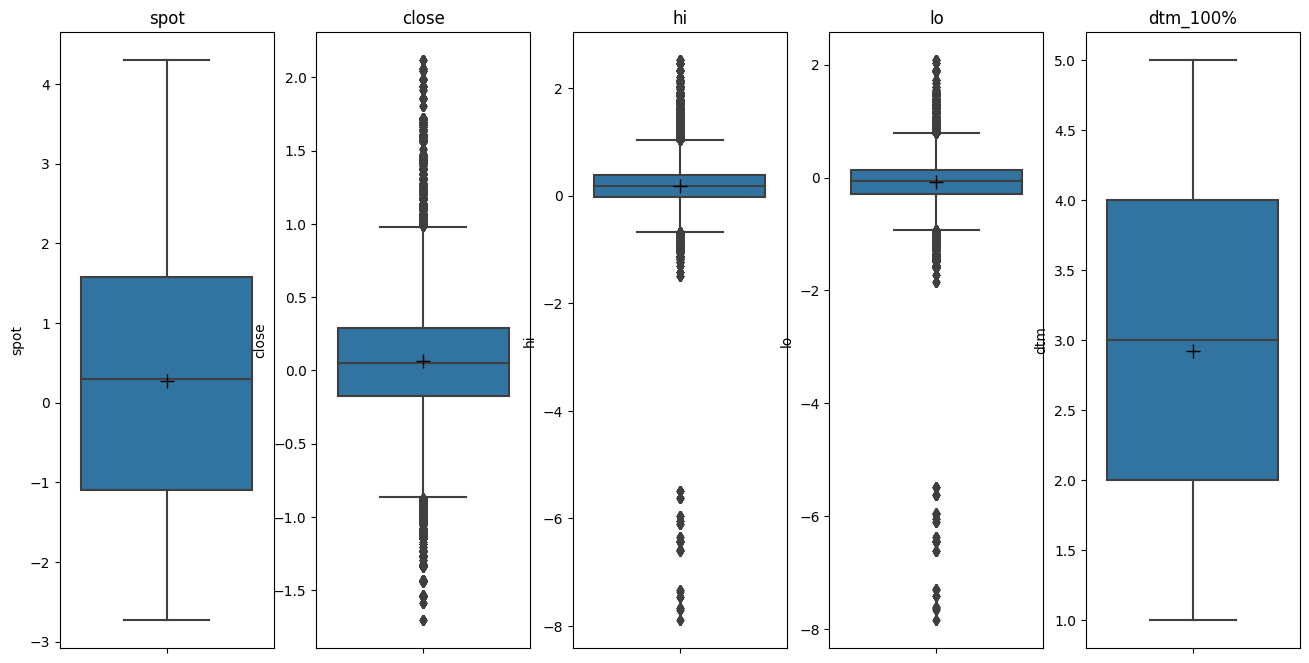

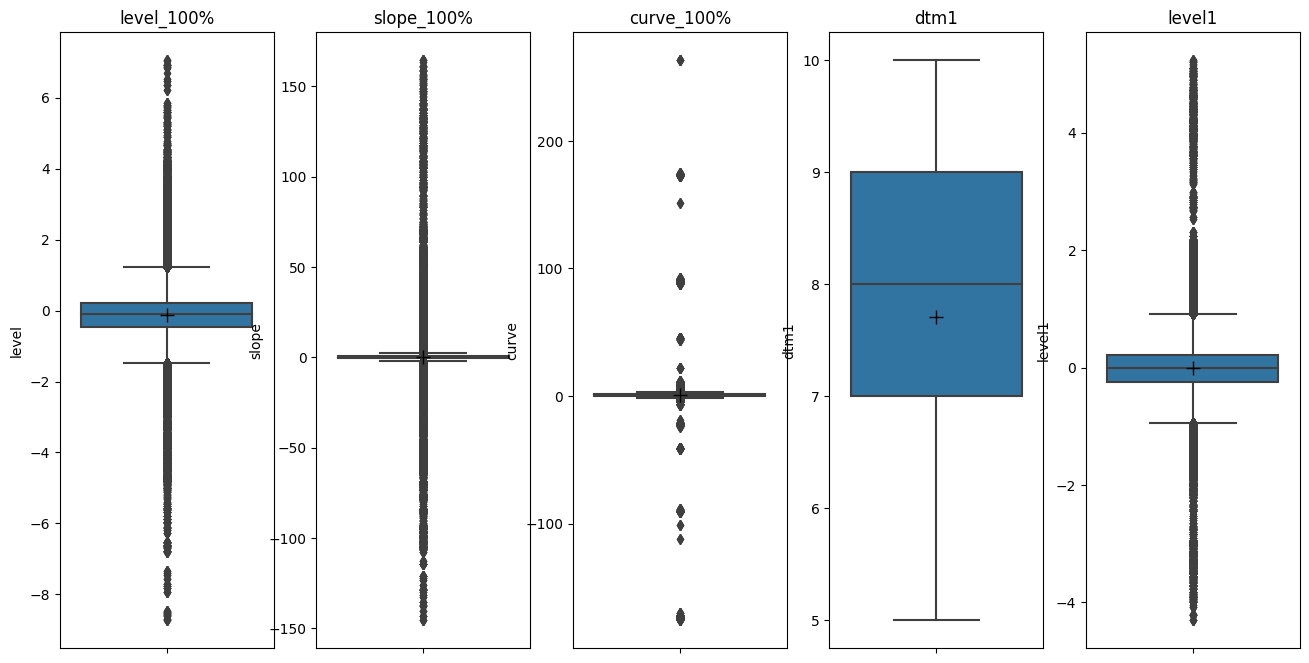

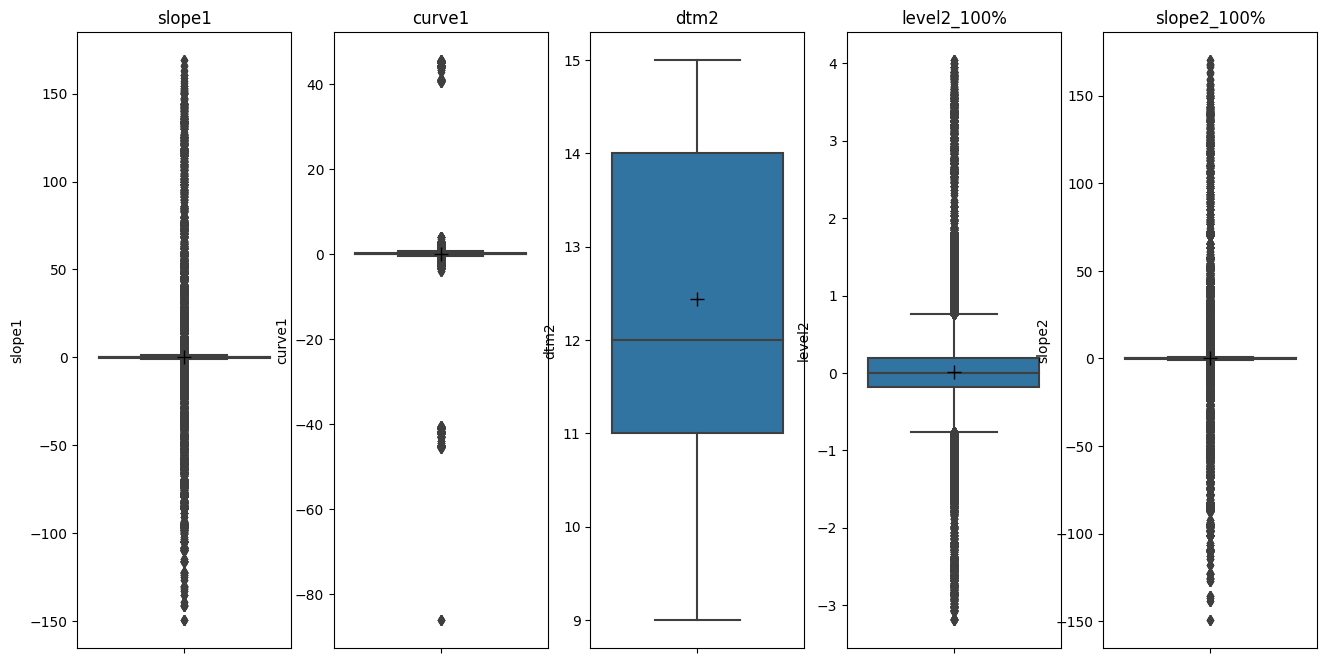

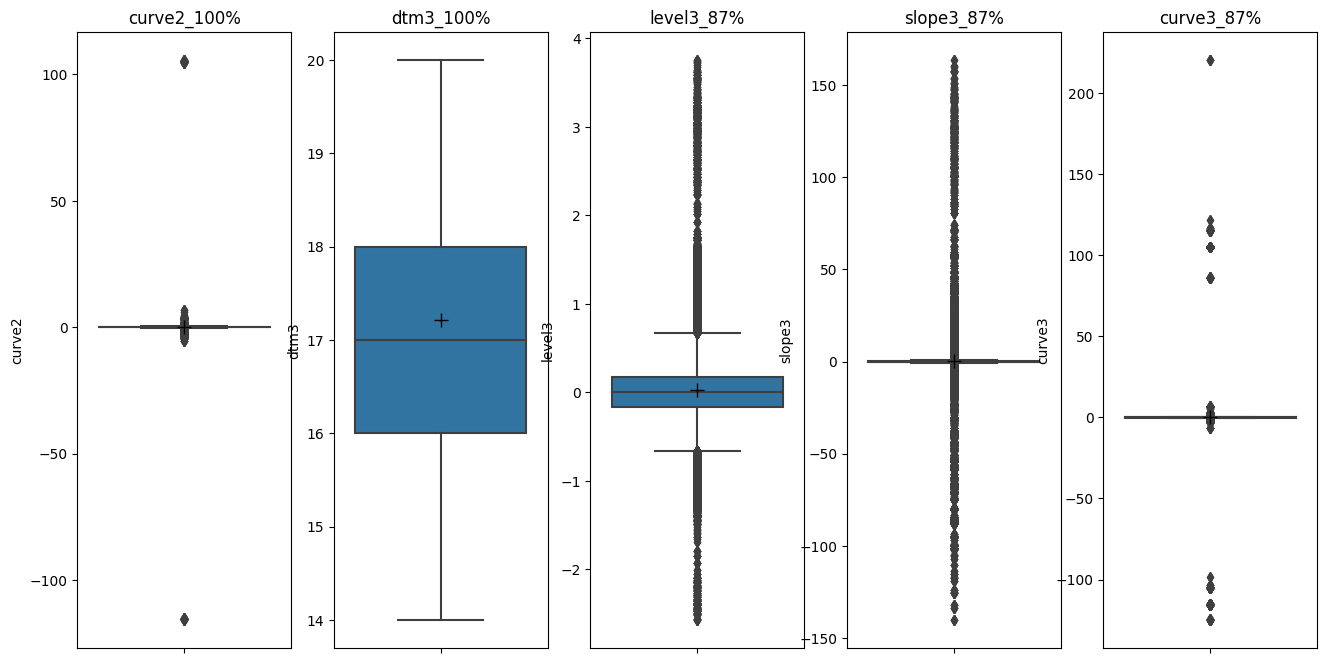

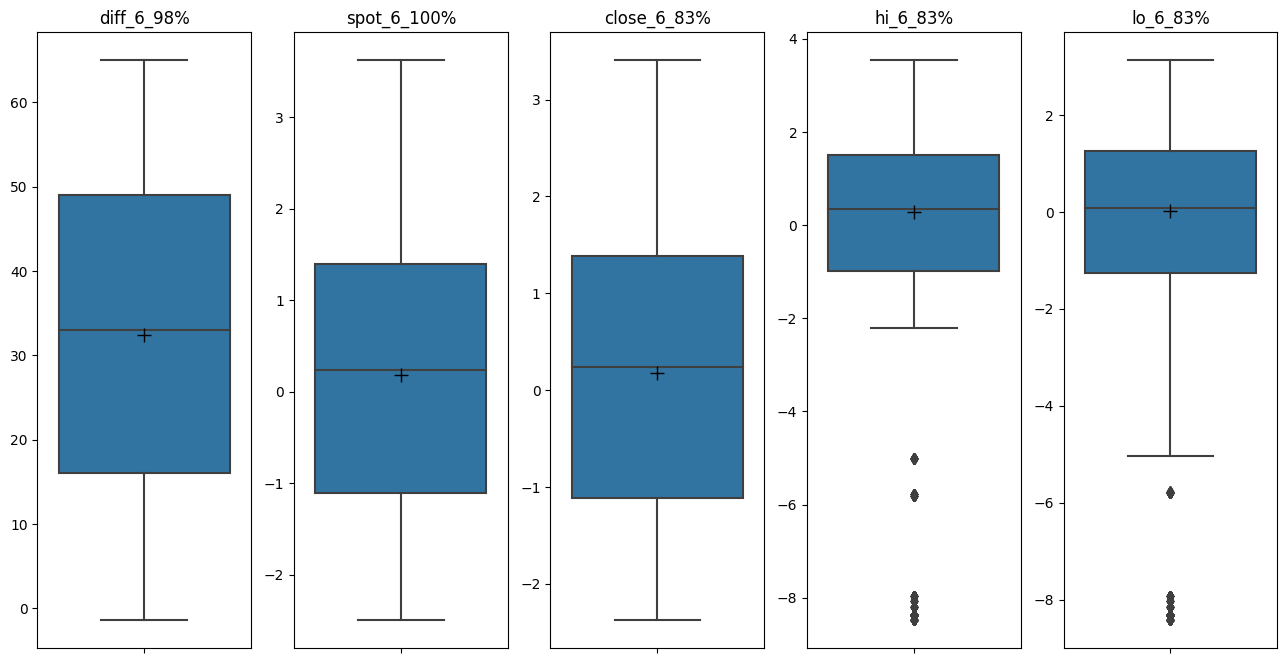

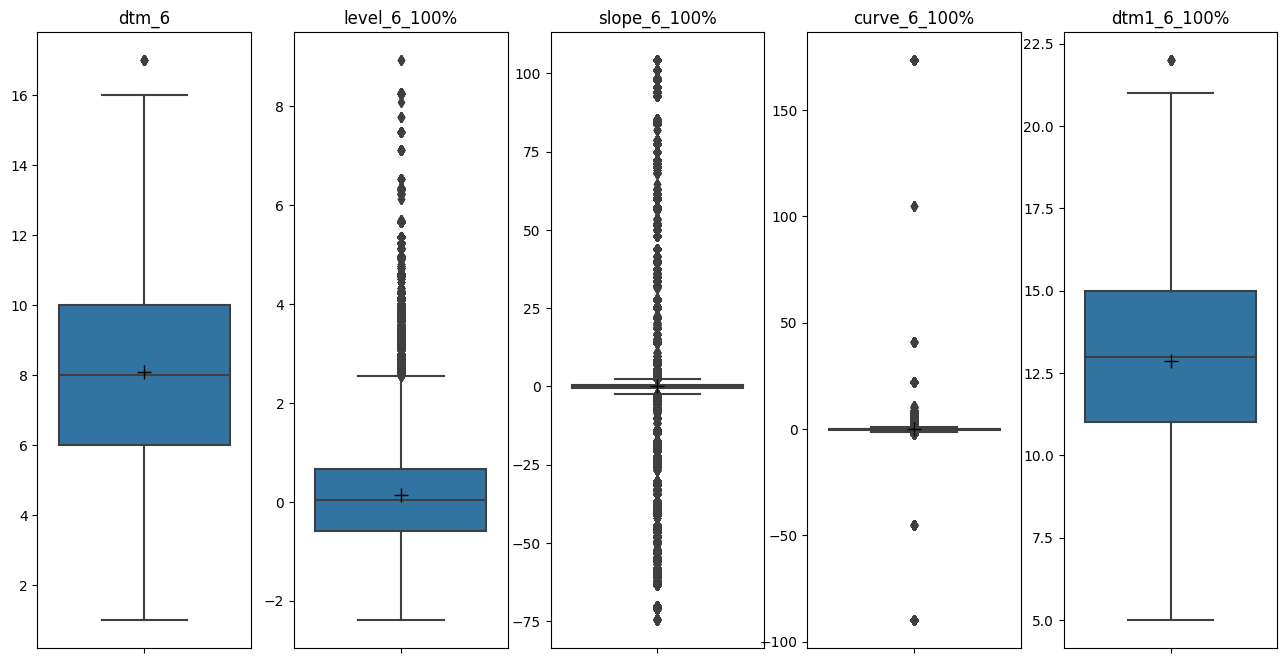

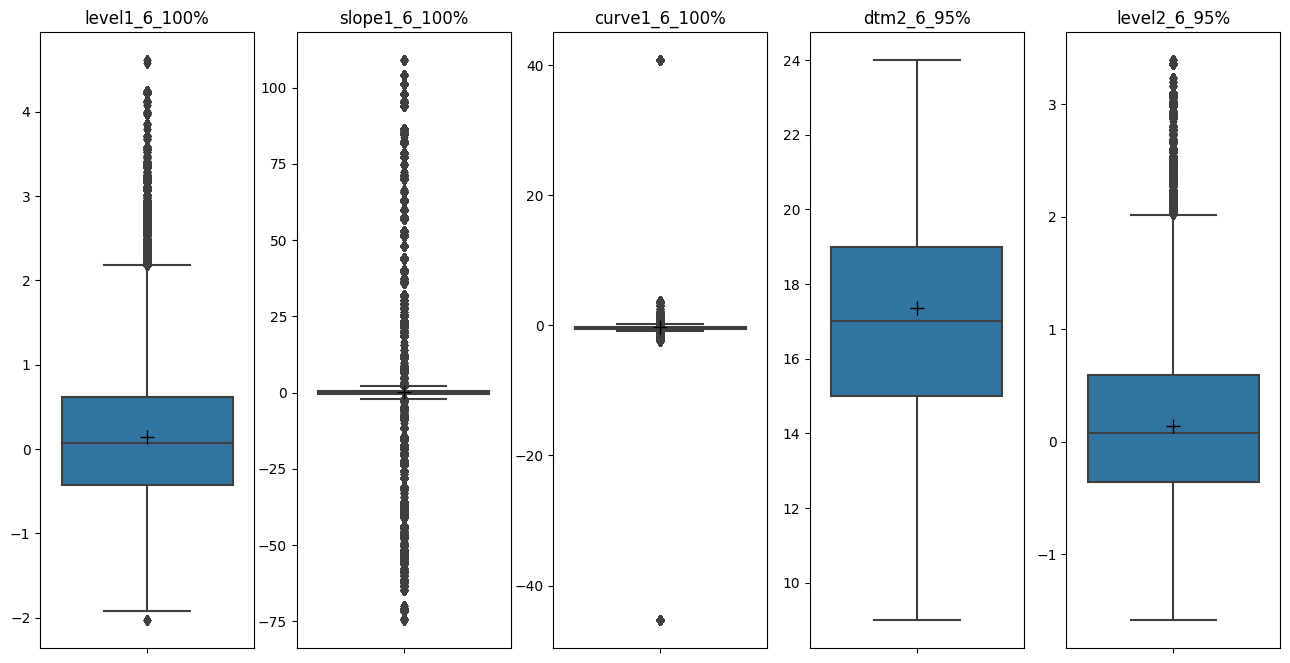

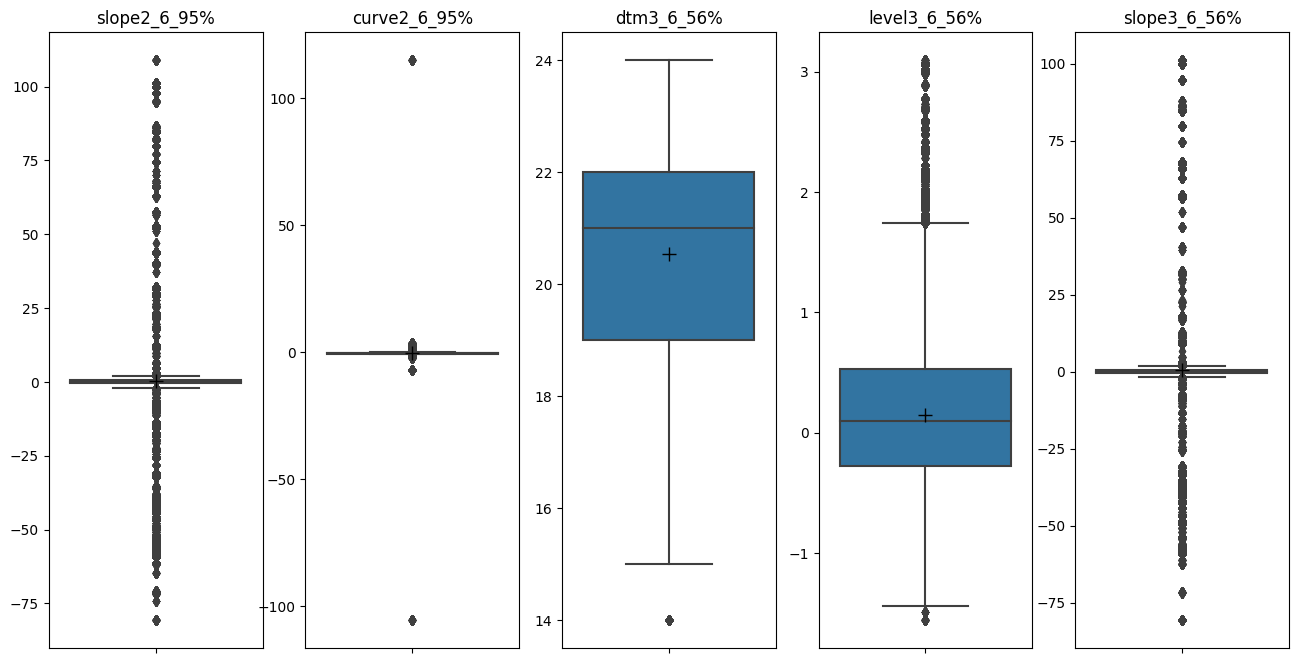

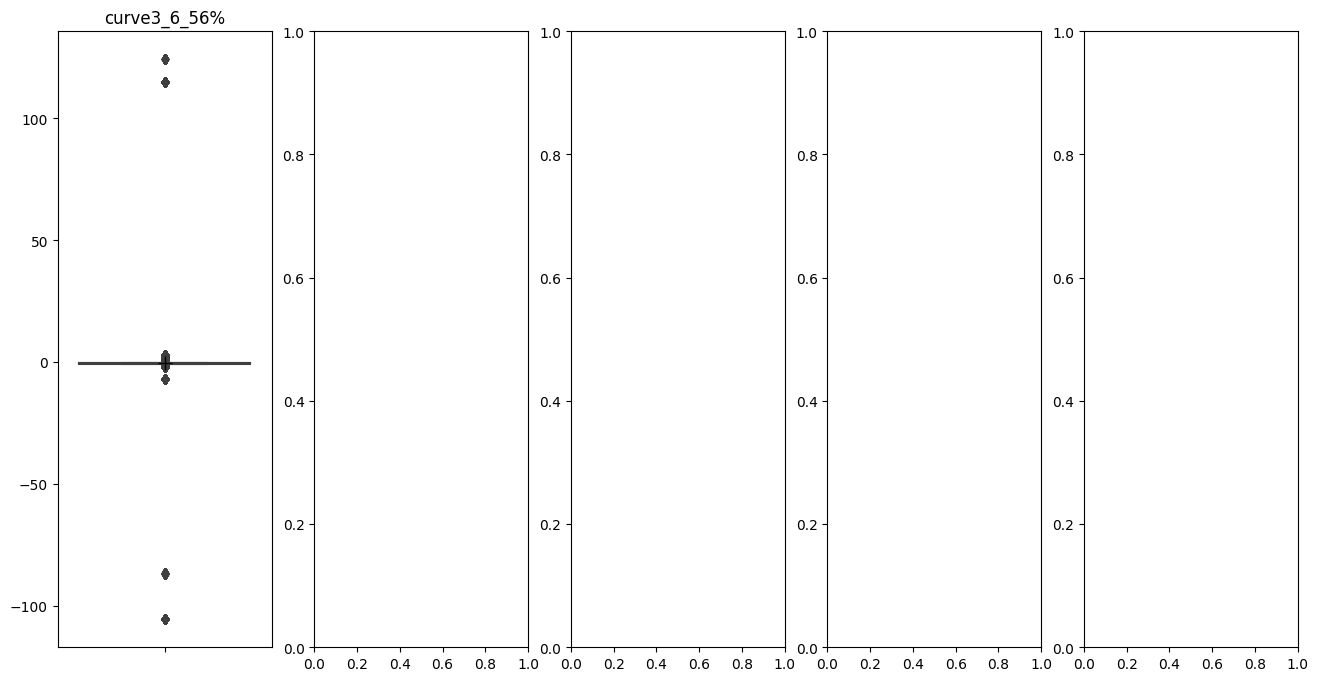

In [4]:
next_dep = 0
# next_dep=1
# next_dep=2
# next_dep=3
resume = True  # False#
# batch_size = 256
# tables = ['volcva.csv']

dfo = pd.DataFrame()
for table in tables:
    df = pd.read_csv(mydrive + table)
    if mergedays:
        df['day'] = pd.to_datetime(df['date'].str.replace('#', '')).dt.date
        df['Horizon'] += df['diff_5'] - df['diff_6']
        lasttime = df.groupby(['day'])['date'].max().values
        df = df[(df['date'].isin(lasttime)) & (df['Horizon'] > 0)]
        lasttime = df[['date', 'Horizon', 'dtm']].groupby(['date', 'Horizon']).first()
        df = pd.merge(lasttime, df, on=['date', 'Horizon', 'dtm'])
    dfo = pd.concat([dfo, df])

cont_names=[]
for var in vars_h:
    for i in range(duration):
        mvar = f'{var}_{i+1}'
        if not mvar in dfo.columns:
            dfo[mvar] = 0
        cont_names.append(mvar)

dfo.sort_values(by=['date'])
enc = OrdinalEncoder()
dfo[cat_names] = enc.fit_transform(dfo[cat_names])
X_all = dfo.loc[:, cat_names + vars_c + cont_names].to_numpy().astype('float32')

print(dfo.shape, X_all.shape,len(dep_vars[0]))
print(dfo['close'].quantile([(i + 1.) / 22. for i in range(22)]))
boxplot(vars_h[1:],bad_value)
boxplot([[f'{var}_{i+1}' for i in range(duration)] for var in vars_h[1:]],0)


In [ ]:
with pd.option_context('display.max_colwidth', None,'display.max_rows', None):
  display(dfo[dfo['dtm_1']>15].iloc[0])

date            #2022-06-24 16:00:07#
Horizon                           5.0
dtm                                 5
spot                         -1.35736
level                        -1.26966
slope                        -0.20132
curve                         0.58794
dtm1                                9
level1                       -1.12212
slope1                       -0.03886
curve1                        0.32424
dtm2                               14
level2                       -1.02512
slope2                        0.30494
curve2                       -0.01554
dtm3                               19
level3                       -99999.0
slope3                       -99999.0
curve3                       -99999.0
date_1                    44720.41595
date_2                    44721.66555
date_3                    44722.66425
date_4                     44725.6638
date_5                    44727.58959
date_6                     44728.5474
diff_1                             54
diff_2      

# run


Xcf_dtm,leve torch.Size([241386, 16])
PETrans 6 16 132 [] 16 2
offset  -69551
torch.Size([196729, 0]) torch.Size([196729, 22, 6]) torch.Size([196729, 16])
Xcf_dtm,leve 5.7851


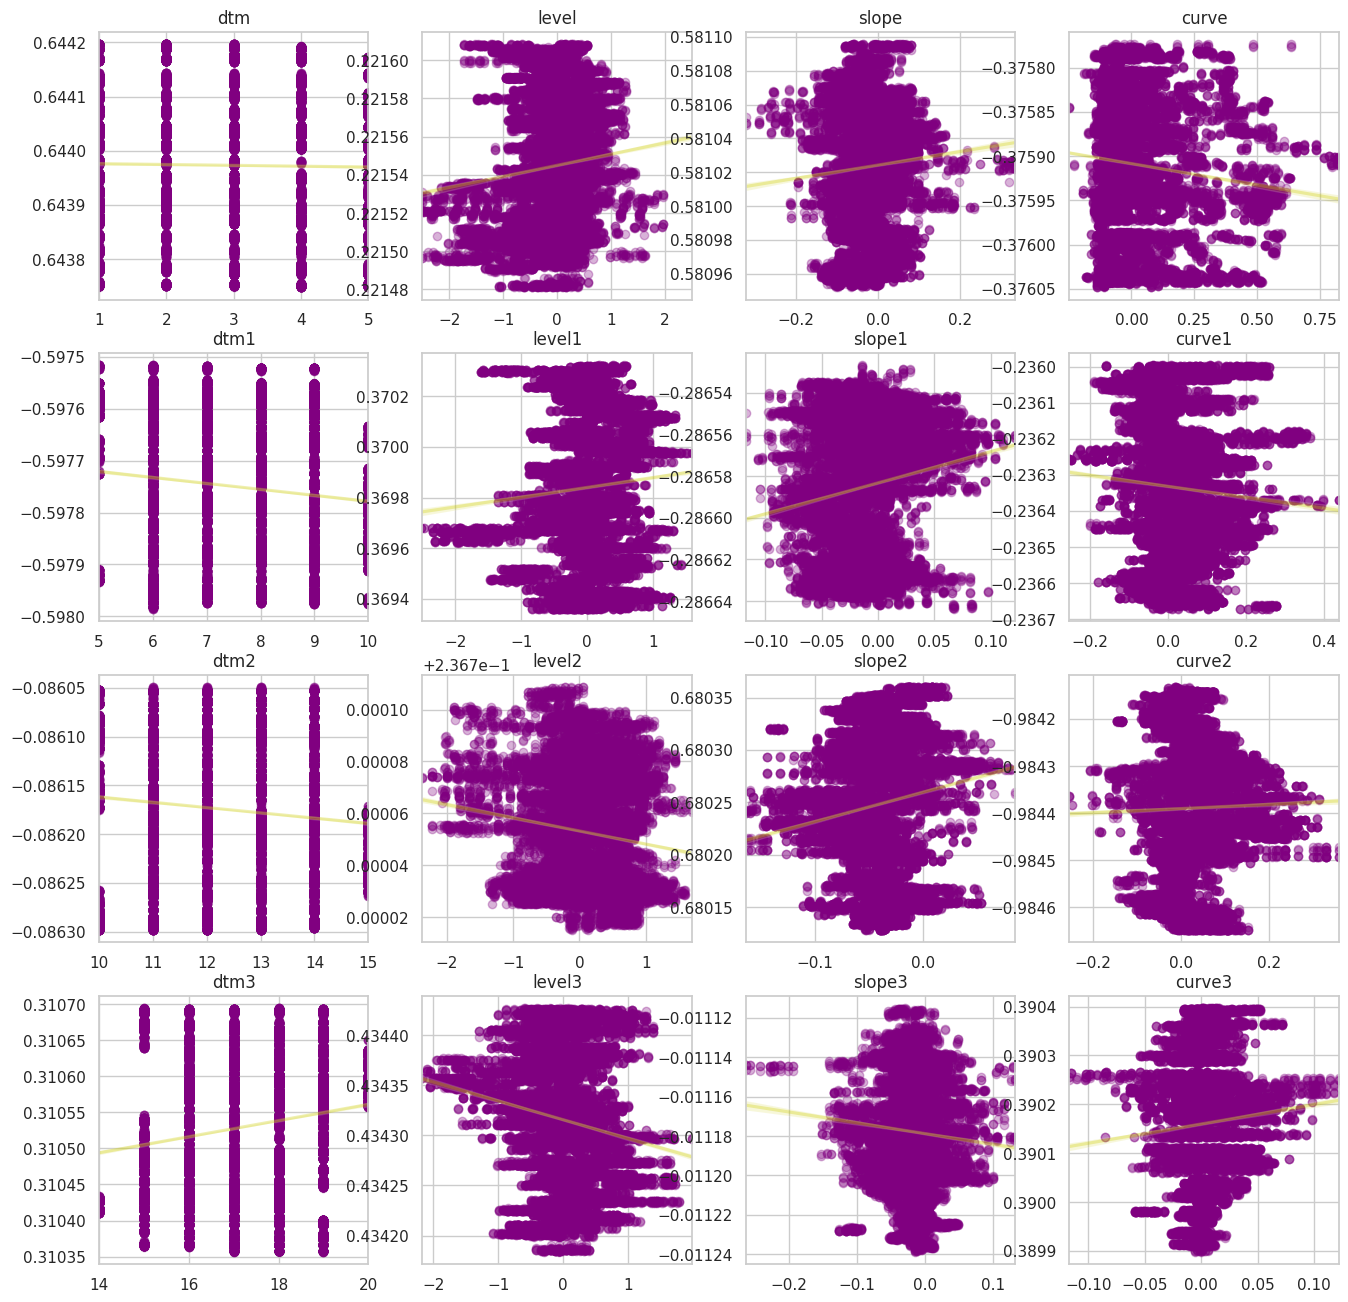

In [ ]:
# next_dep=0
# resume=False#
# resume=True#False#
# batch_size = 128
# ignore_load_error=True
# ignore_load_zero=True

n_epochs = 900
n_trials = 50
start_epoch = 1
sub_epochs=10

for dep_sec in range(next_dep, len(dep_vars)):
    n_no_improve = 0
    setup_data(dep_sec)
    print(X['train'][0].shape, X['train'][1].shape, y['train'].shape)
    validate()
    resume=True
    # report_frequency = len(X['train']) // batch_size // 5
    for epoc in range(start_epoch, n_epochs , sub_epochs):
      for epoch in range(epoc,epoc+sub_epochs):
        for iteration, batch_idx in enumerate(train_loader):
            my_model.train()
            optimizer.zero_grad()
            x_batch = (X['train'][0][batch_idx] if len(cat_names)>0 else None,
                       X['train'][1][batch_idx],
                       X['train'][2][batch_idx])
            y_batch = y['train'][batch_idx]
            loss = loss_fn(
                apply_model(my_model,
                            x_cat=x_batch[0] if len(cat_names)>0 else None,
                            x_num=x_batch[1], x2=x_batch[2]).squeeze(1),
                y_batch)
            loss.backward()
            optimizer.step()
            # if iteration % report_frequency == 0:
            #     print(f'(epoch) {epoch} (batch) {iteration} (loss) {loss.item():.4f}')

        val_score = evaluate()[0]
        # test_score = evaluate(my_model,'test')[0]
        print(f'Epoch {epoch:03d} | Validation score: {val_score:.4f}', end=" ")
        progress.update(-val_score)
        if progress.success:
            print(' <<< BEST VALIDATION EPOCH')
            save_model(True)
            n_no_improve = 0
        else:
            save_model(False)
            n_no_improve += 1
            print(f' no improve {n_no_improve}')
        if progress.fail or val_score < .01 or n_no_improve > n_trials:
            break
      if progress.fail or val_score < .01 or n_no_improve > n_trials:
        break
      if n_no_improve<sub_epochs:
        load_model()
      else:
        print("noload",n_no_improve,sub_epochs)
    with open(mydrive + jobname, 'wb') as filehandler:
        dump((my_model, y_std, y_mean, enc), filehandler)
    validate()

## manual

In [ ]:

    setup_data(0)
    prediction = []
    i=0
    # batch_size=64
    with torch.no_grad():
      my_model.eval()
      for batch in zero.iter_batches(X['test'], batch_size):
      # batch=next(zero.iter_batches(X['test'], batch_size))
      # if True:
        prediction.append(apply_model(my_model,
                                      x_cat=batch[0] if len(cat_names)>0 else None,
                                      x_num=batch[1],x2=batch[2]))
    prediction = torch.cat(prediction)
    target = y['test']#[i:i+batch_size]
    if task_type == 'binclass':
      prediction = np.round(scipy.special.expit(prediction))
      score = sklearn.metrics.accuracy_score(target, prediction)
    elif task_type == 'multiclass':
      prediction = prediction.argmax(1)
      score = (target.reshape(-1)!=prediction).sum()/len(prediction)
    else:
      assert task_type == 'regression'
      score =mse_loss_with_nans(prediction, target, ) ** 0.5

    score,target, prediction


Xcf_dtm, lev torch.Size([231363, 16])
PETrans 6 16 132 [] 16 2
loaded Xcf_dtm, lev epoch 74
offset  -64321


(tensor(0.7848, device='cuda:0'),
 tensor([[ 4.0000e+00, -1.3228e-02, -1.0274e-01,  ...,  1.0533e-01,
           9.5372e-01,  2.4700e-01],
         [ 2.0000e+00,  1.2167e-01, -1.5562e-02,  ..., -7.9616e-02,
           9.9181e-03, -1.7748e-01],
         [ 1.0000e+00, -8.4570e-01,  3.6727e-01,  ..., -1.1988e-01,
          -1.0307e+00,  1.2879e+00],
         ...,
         [ 2.0000e+00, -2.0026e+00,  1.0725e+00,  ..., -6.1677e-01,
           2.8542e-03,  3.8150e-02],
         [ 4.0000e+00, -1.3515e-01, -4.9724e-01,  ..., -3.6680e-02,
          -2.7041e-01, -4.6244e-01],
         [ 4.0000e+00, -1.9064e+00,  1.9062e-02,  ..., -1.5916e+00,
          -8.3080e-01,  6.4188e-01]], device='cuda:0'),
 tensor([[ 3.6312,  0.2111, -0.2651,  ...,  0.0109,  0.1032,  0.4787],
         [ 1.0670,  0.5796, -0.1153,  ...,  0.1862, -0.2249, -0.0291],
         [ 0.9954, -0.9162, -0.0798,  ..., -0.5044, -0.1970,  0.4467],
         ...,
         [ 1.7209,  0.0851,  0.0357,  ...,  0.0411,  0.1121,  0.0917],
     

In [ ]:
for i in range(len(target)):
  if target[i][0]==1 and prediction[i][0]>2:
    print(i,target[i],prediction[i])

15382 tensor([ 1.0000e+00,  6.0205e-01, -4.2817e-01,  1.0109e+00,  5.0000e+00,
         4.9149e-01, -2.0451e-01, -4.4114e-01,  1.0000e+01,  1.5667e-01,
         2.5629e-01, -7.5276e-01,  1.5000e+01,  1.1539e-01, -9.2124e-01,
        -6.9835e-03], device='cuda:0') tensor([ 2.6289,  0.2052,  0.0468, -0.5407,  7.4679,  0.1687,  0.1701, -0.5982,
        12.2171,  0.0882,  0.0640, -0.2971, 16.9601,  0.0372,  0.1261, -0.1165],
       device='cuda:0')
18262 tensor([ 1.0000e+00,  3.3884e-02,  2.2153e-03, -5.6351e-01,  5.0000e+00,
         2.6321e-02, -6.4948e-01, -7.7102e-02,  1.0000e+01, -5.2886e-02,
        -4.5381e-01, -2.7395e-01,  1.5000e+01, -7.9756e-02, -5.3078e-01,
        -5.1002e-02], device='cuda:0') tensor([ 2.6289,  0.2052,  0.0468, -0.5407,  7.4679,  0.1687,  0.1701, -0.5982,
        12.2170,  0.0882,  0.0641, -0.2971, 16.9601,  0.0371,  0.1262, -0.1164],
       device='cuda:0')


In [ ]:
X['test'][1][15382]

tensor([[ 4.5008e+04,  4.5009e+04,  4.5012e+04,  4.5013e+04,  4.5014e+04,
          4.5015e+04],
        [ 1.9000e+01,  1.8000e+01,  1.7000e+01,  1.6000e+01,  1.5000e+01,
          1.4000e+01],
        [ 8.9200e-01,  6.5130e-01,  8.3350e-01,  5.9524e-01,  7.5202e-01,
          7.5577e-01],
        [ 6.7622e-01,  6.1581e-01,  6.6252e-01,  5.7502e-01,  7.3174e-01,
          0.0000e+00],
        [ 9.1331e-01,  6.8090e-01,  8.4899e-01,  6.8063e-01,  7.7885e-01,
          0.0000e+00],
        [ 5.5699e-01,  5.0680e-01,  6.0004e-01,  4.4932e-01,  5.8333e-01,
          0.0000e+00],
        [ 1.0000e+01,  9.0000e+00,  8.0000e+00,  3.0000e+00,  2.0000e+00,
          1.0000e+00],
        [ 1.7966e-01,  6.6529e-01,  2.8923e-01, -1.0150e+00, -1.3017e+00,
         -1.3386e+00],
        [-3.4110e-01, -6.2850e-02, -8.4301e-01,  1.2669e-01,  3.7919e-01,
          2.8574e-01],
        [-2.7843e-01, -4.4193e-01, -6.6077e-01,  2.9663e-01,  8.3829e-01,
          1.5170e+00],
        [ 1.5000e+01,  1.4000e

In [ ]:
dfo[(dfo['dtm']==1)&(dfo['diff_1']==19)&(dfo['dtm_1']==10)]

,date,Horizon,spot,dtm,level,slope,curve,dtm1,level1,slope1,...,lo_5,close_1,close_2,close_3,close_4,close_5,Unnamed: 152,close_6,hi_6,lo_6
29164,#2022-08-11 11:00:30#,4,-0.24044,1,-0.62280,1.03613,2.18898,6,-0.04398,-0.30333,...,-0.16454,-0.32188,-0.24860,-0.22620,-0.12949,-0.04464,NaN,0,0,0
29166,#2022-08-11 14:34:13#,4,-0.34353,1,0.12746,0.02119,2.63022,6,0.12191,-0.08716,...,-0.16454,-0.32186,-0.24863,-0.22623,-0.12950,-0.04463,NaN,0,0,0
29167,#2022-08-11 15:49:20#,4,-0.39425,1,-0.09963,0.79545,5.19565,6,0.04090,-0.41829,...,-0.16453,-0.32190,-0.24860,-0.22623,-0.12950,-0.04463,NaN,0,0,0
29168,#2022-08-11 16:01:24#,4,-0.37708,1,0.20958,8.83019,0.51326,6,0.26814,-0.58919,...,-0.16456,-0.32186,-0.24862,-0.22621,-0.12950,-0.04463,NaN,0,0,0
29193,#2022-08-11 11:00:30#,4,-0.24038,1,-0.62199,1.03611,2.18832,6,-0.04424,-0.30349,...,-0.16455,-0.32188,-0.24864,-0.22622,-0.12949,-0.04464,NaN,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26375,#2023-07-13 15:22:03#,3,1.77185,1,0.38599,11.32070,0.55480,6,-0.29298,0.15037,...,1.70838,1.65868,1.99378,1.87829,1.79175,1.74200,NaN,0,0,0
26376,#2023-07-13 15:58:10#,3,1.73643,1,0.62053,8.16678,1.49986,6,-0.09982,0.52025,...,1.70825,1.65856,1.99354,1.87819,1.79180,1.74183,NaN,0,0,0
26390,#2023-07-13 10:13:31#,3,1.68760,1,-0.55298,2.02392,3.89535,6,-0.29833,0.39798,...,1.70818,1.65851,1.99380,1.87795,1.79176,1.74199,NaN,0,0,0
26391,#2023-07-13 15:22:03#,3,1.77103,1,0.38587,11.32026,0.55478,6,-0.29345,0.15023,...,1.70826,1.65838,1.99353,1.87817,1.79156,1.74190,NaN,0,0,0


In [ ]:
dfo[(dfo['dtm_1']>15)]

,date,Horizon,spot,dtm,level,slope,curve,dtm1,level1,slope1,...,lo_5,close_1,close_2,close_3,close_4,close_5,Unnamed: 152,close_6,hi_6,lo_6
18903,#2022-06-24 09:30:32#,5,-1.53904,5,-1.03273,-0.22113,0.37793,9,-0.89274,-0.16498,...,-1.68831,-0.91399,-1.08469,-1.39007,-1.76755,-1.51708,NaN,0,0,0
18904,#2022-06-24 16:00:07#,5,-1.35736,5,-1.26966,-0.20132,0.58794,9,-1.12212,-0.03886,...,-1.68817,-0.91386,-1.08458,-1.38994,-1.76736,-1.51726,NaN,0,0,0
18922,#2022-06-24 09:30:32#,5,-1.54002,5,-1.03296,-0.22088,0.37793,9,-0.89272,-0.16497,...,-1.68814,-0.91393,-1.08450,-1.39000,-1.76751,-1.51735,NaN,0,0,0
18923,#2022-06-24 16:00:07#,5,-1.35702,5,-1.26966,-0.20118,0.58802,9,-1.12209,-0.03884,...,-1.68808,-0.91387,-1.08451,-1.39008,-1.76752,-1.51706,NaN,0,0,0
18941,#2022-06-24 09:30:32#,5,-1.53879,5,-1.03297,-0.22076,0.37792,9,-0.89291,-0.16477,...,-1.68808,-0.91392,-1.08453,-1.39012,-1.76760,-1.51731,NaN,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29682,#2023-08-04 15:58:25#,5,0.64482,5,-0.15748,0.58193,0.59598,10,-0.12435,0.67900,...,1.48614,1.47181,1.38112,1.44282,1.50911,1.57617,NaN,0,0,0
29696,#2023-08-04 11:58:44#,5,0.89722,5,-0.57176,1.26835,0.62479,10,-0.42320,0.66933,...,1.48609,1.47172,1.38105,1.44284,1.50900,1.57598,NaN,0,0,0
29697,#2023-08-04 15:58:25#,5,0.64446,5,-0.15746,0.58198,0.59624,10,-0.12429,0.67855,...,1.48624,1.47179,1.38100,1.44278,1.50897,1.57608,NaN,0,0,0
29711,#2023-08-04 11:58:44#,5,0.89725,5,-0.57168,1.26720,0.62471,10,-0.42310,0.66921,...,1.48635,1.47188,1.38111,1.44286,1.50909,1.57627,NaN,0,0,0


In [ ]:
with pd.option_context('display.max_colwidth', None,'display.max_rows', None):
  display(dfo[(dfo['dtm']==1)&(dfo['diff_1']==19)&(dfo['dtm_1']==10)&(dfo['Horizon']<4)].iloc[10])

date            #2022-10-06 10:29:58#
Horizon                             2
spot                         -0.94172
dtm                                 1
level                        -0.13269
slope                         1.34783
curve                         0.38551
dtm1                                6
level1                        0.06577
slope1                        0.27589
curve1                        0.10309
dtm2                               11
level2                        0.10553
slope2                         0.2063
curve2                        0.06762
dtm3                               16
level3                        0.09173
slope3                        0.19436
curve3                       -0.00611
date_1                    44827.66397
date_2                    44830.66464
date_3                    44833.57739
date_4                    44834.44378
date_5                     44837.3959
date_6                    44838.55333
diff_1                             19
diff_2      

Xcf_dtm, lev 0.7848


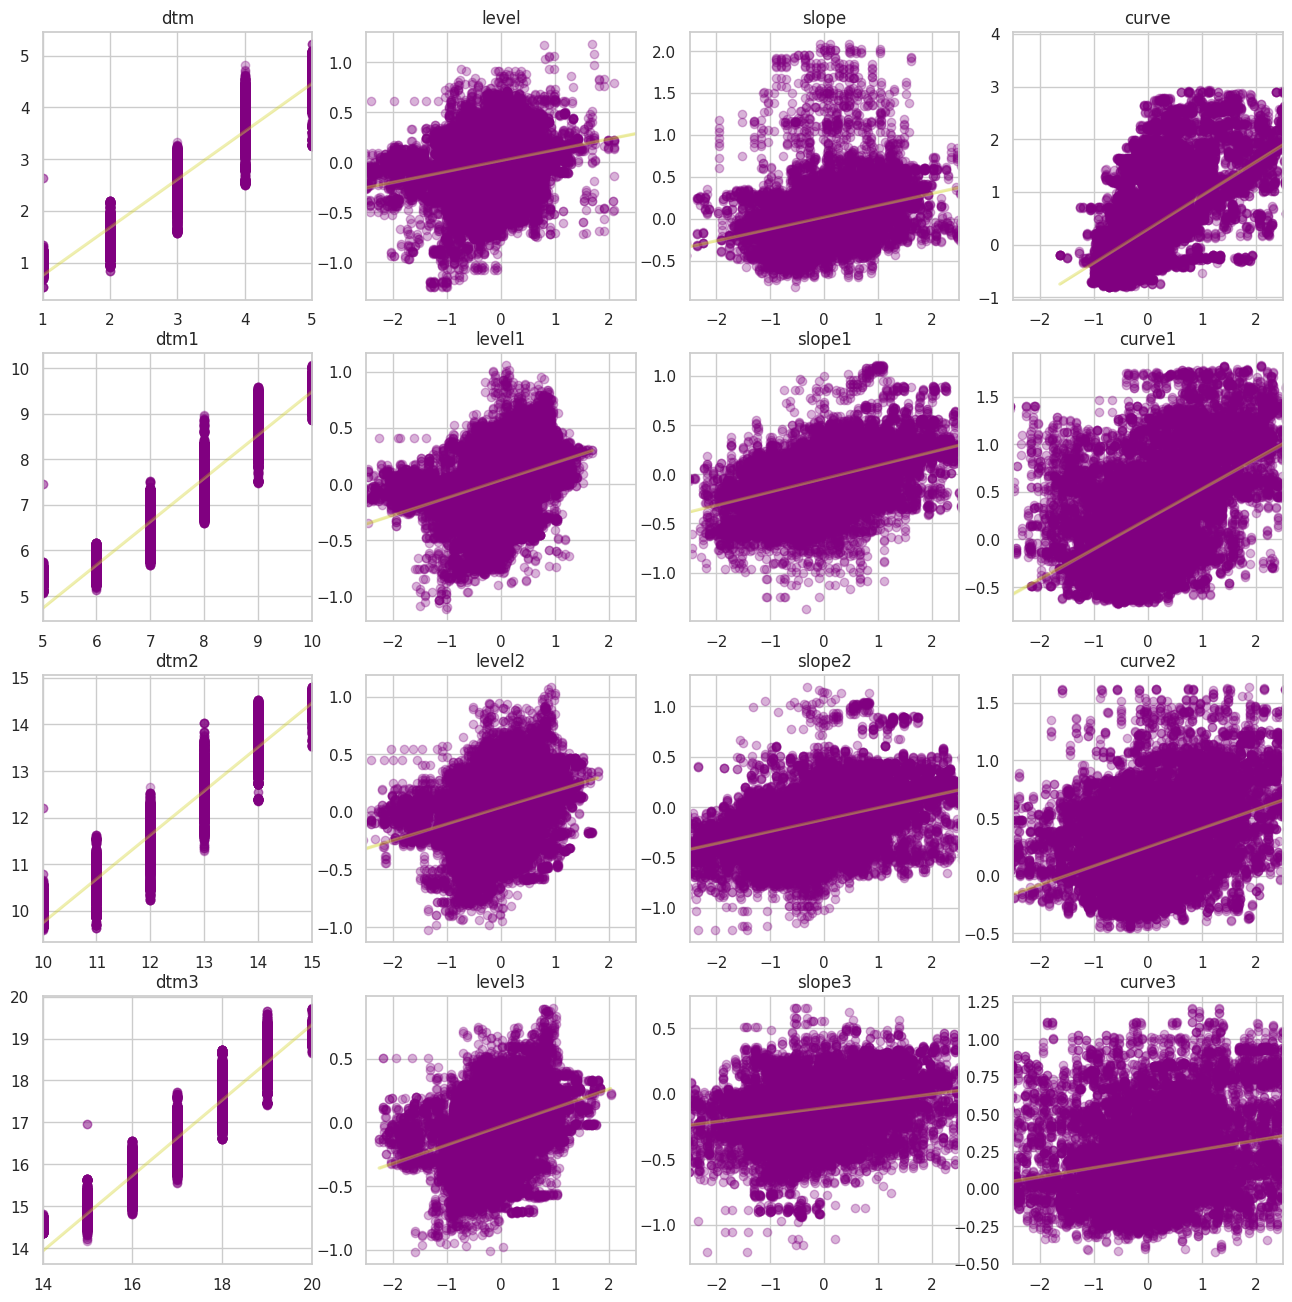

In [ ]:
validate()

Xcf_pmcat] torch.Size([66163])
PETrans 5 16 110 [] 22 0
loaded Xcf_pmcat] epoch 261
offset  -14784
Xcf_pmcat] 0.9022


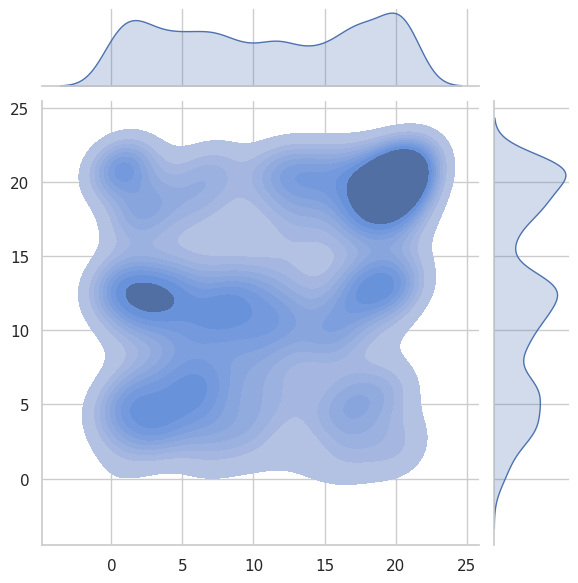

In [ ]:
setup_data(1)
validate()

## export

In [ ]:
ignore_load_zero=True
ignore_load_error=True
for dep_sec,dep_var in enumerate(dep_vars):
    if len(dep_var)>0:
      setup_data(dep_sec)
      with open(mydrive + jobname, 'wb') as filehandler:
          dump((my_model, y_std, y_mean, enc), filehandler)

Xcf_close, h torch.Size([66163, 3])
PETrans 5 16 110 [] 3 0
loaded Xcf_close, h epoch 227
offset  -15779
Xcf_pmcat] torch.Size([66163])
PETrans 5 16 110 [] 22 0
loaded Xcf_pmcat] epoch 603
offset  -14784


#valid

In [ ]:
last_run = "2023-08-19"
next_run = "2023-07-08"

models, cont_names = [], []
for dep_sec,dep_var in enumerate(dep_vars):
    if len(dep_var)>0:
      jobname = job_name()
      with open(mydrive + jobname, 'rb') as filehandler:
          models.append(load(filehandler))

dfo = pd.DataFrame()
for table in tables:
    df = pd.read_csv(mydrive +'new/'+ table)
    df = df.query(f'date>"#{next_run}"')
    dfo = pd.concat([dfo, df])

for var in vars_h:
    for i in range(duration):
        mvar = f'{var}_{i+1}'
        if not mvar in dfo.columns:
            dfo[mvar] = 0
        cont_names.append(mvar)

dfo[cat_names] = models[0][3].fit_transform(dfo[cat_names])


def val_period():
    global dep_var, jobname, X, y, my_model, y_mean, y_std, task_type
    for period in [[last_run, '9999'], [next_run, last_run]]:
        print(period)
        df = dfo.query(f'date>"#{period[0]}" and date<"#{period[1]}"')
        X, y = ({'test':
                 (  # dfo.loc[:,cat_names+vars_c+cont_names].to_numpy().astype('float32')},{}
                     torch.tensor(df.loc[:, cat_names].to_numpy(), device=device).to(torch.int64),
                     torch.tensor(df.loc[:, cont_names].to_numpy().astype('float32').reshape((df.shape[0], int(len(cont_names) / duration), duration)), device=device),
                     torch.tensor(df.loc[:, vars_c].to_numpy().astype('float32'), device=device),
                 )
                 }, {'test': None})
        print('duration: ', duration,df.shape, X['test'][0].shape, X['test'][1].shape, X['test'][2].shape)

        for learner, dep_var, task_type in zip(models, dep_vars, task_types):
            jobname = job_name()
            my_model, y_std, y_mean, enc = learner
            y['test'] = torch.tensor(df.loc[:, dep_var].to_numpy().astype('float32'if task_type == 'regression' else 'int64'), device=device)
            if task_type=='regression':
              y['test'][y['test']==bad_value]=float('nan')
            validate()

['2023-08-19', '9999']
duration:  5 (4109, 153) torch.Size([4109, 0]) torch.Size([4109, 22, 5]) torch.Size([4109, 0])
Xcf_close, h 0.4508


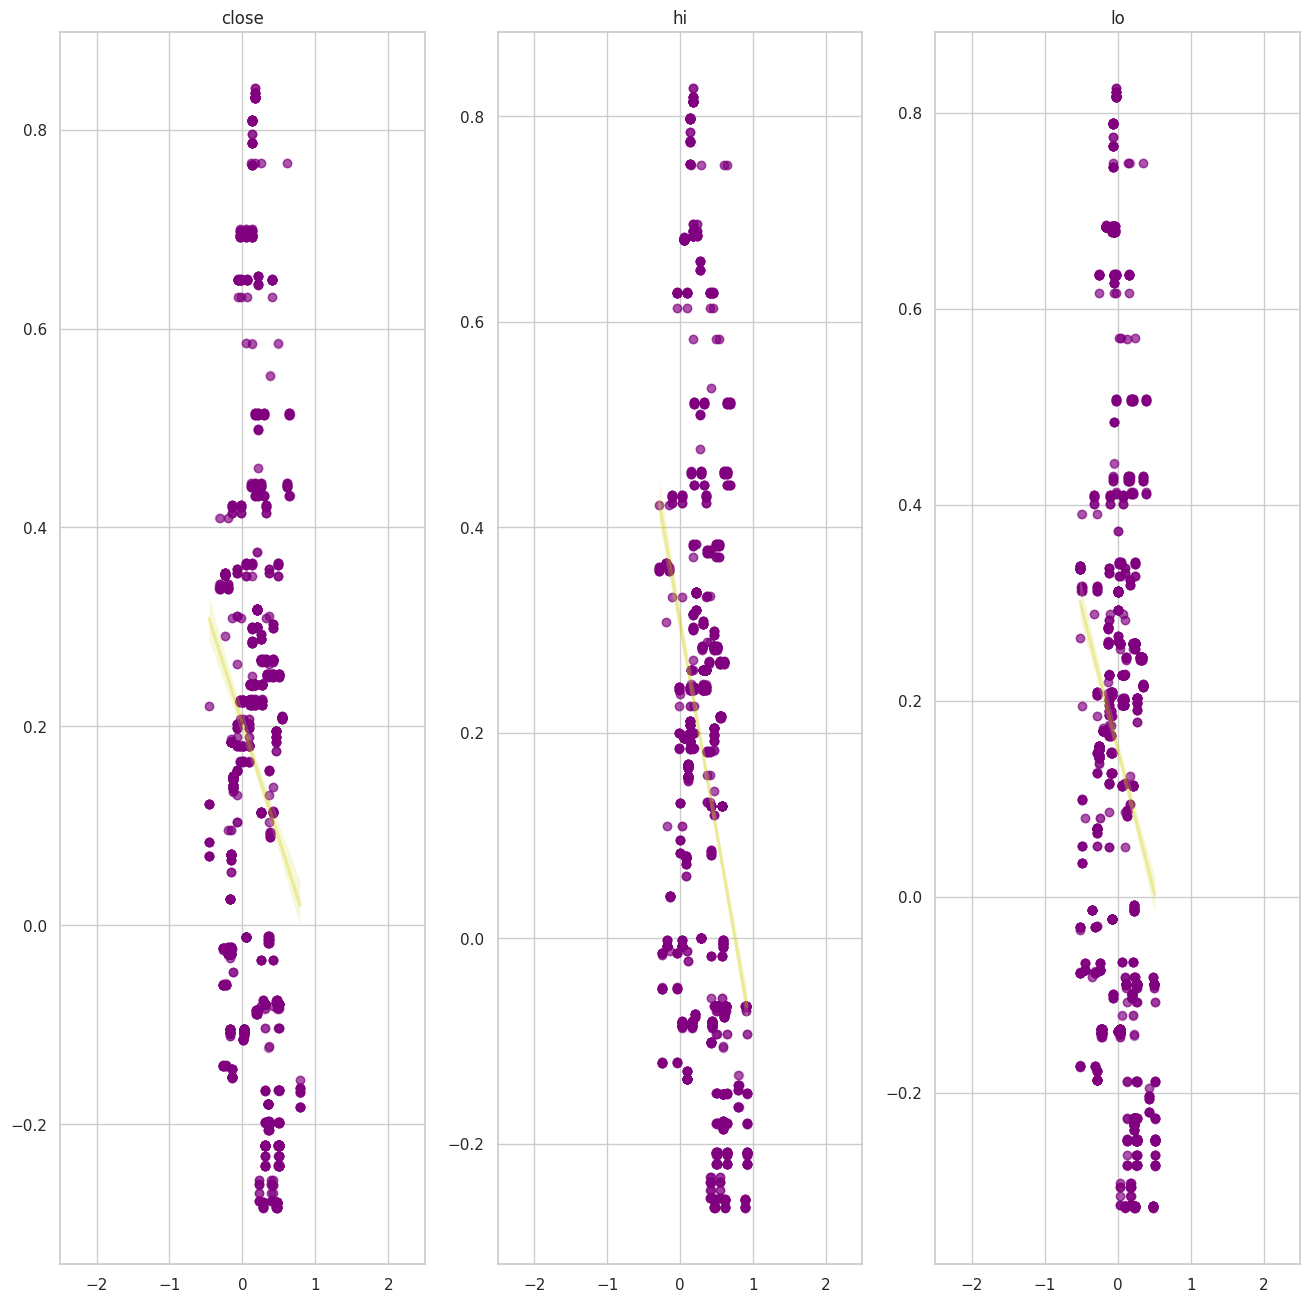

Xcf_pmcat] 0.9606


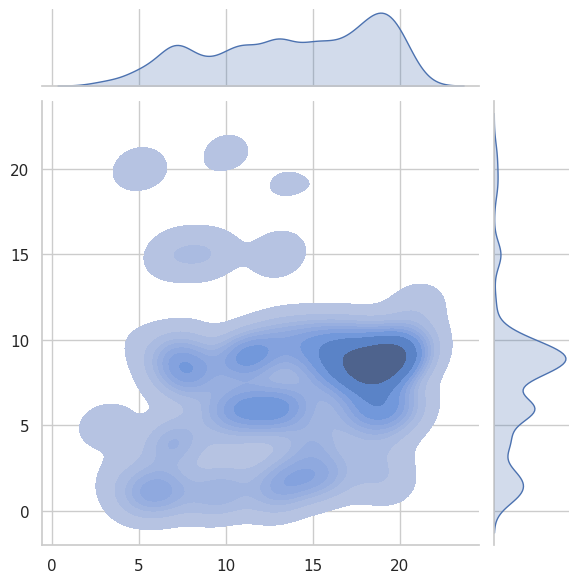

['2023-07-08', '2023-08-19']
duration:  5 (20150, 153) torch.Size([20150, 0]) torch.Size([20150, 22, 5]) torch.Size([20150, 0])
Xcf_close, h 0.4763


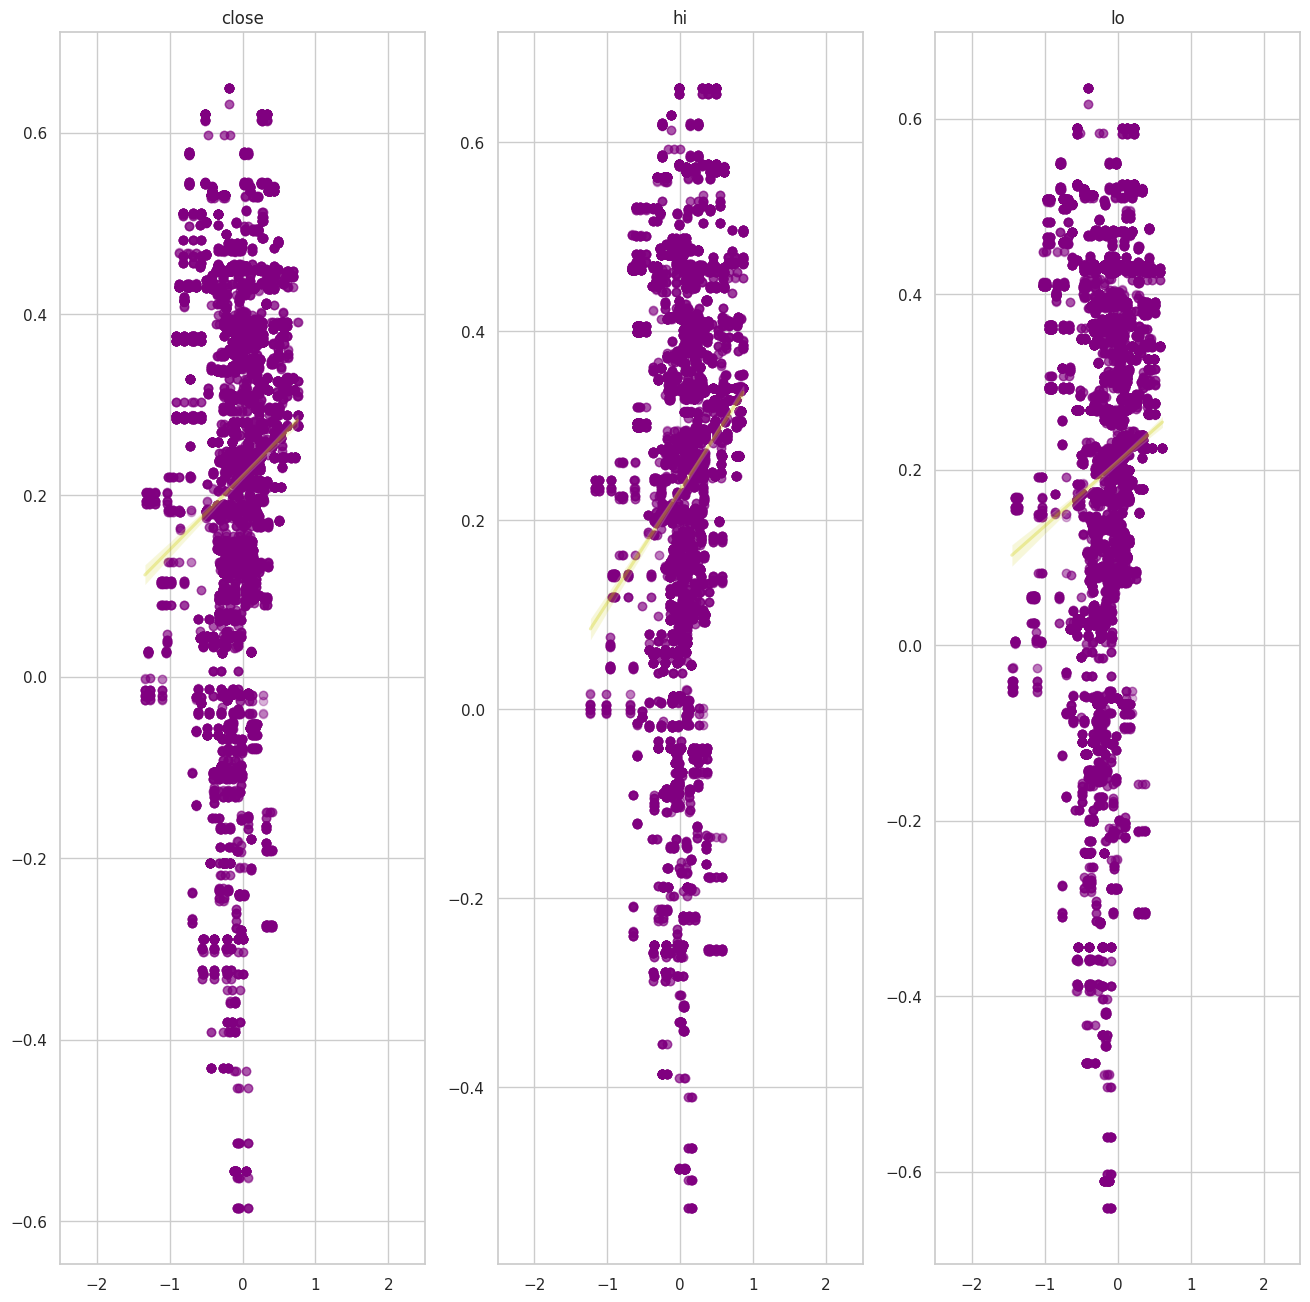

Xcf_pmcat] 0.9231


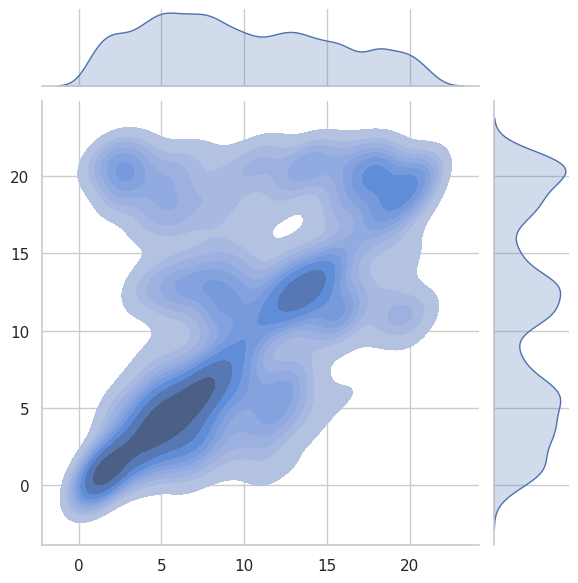

In [ ]:
val_period()

['2023-08-19', '9999']
duration:  6 (4109, 156) torch.Size([4109, 0]) torch.Size([4109, 22, 6]) torch.Size([4109, 2])
Xcf_dtm, lev 0.9200


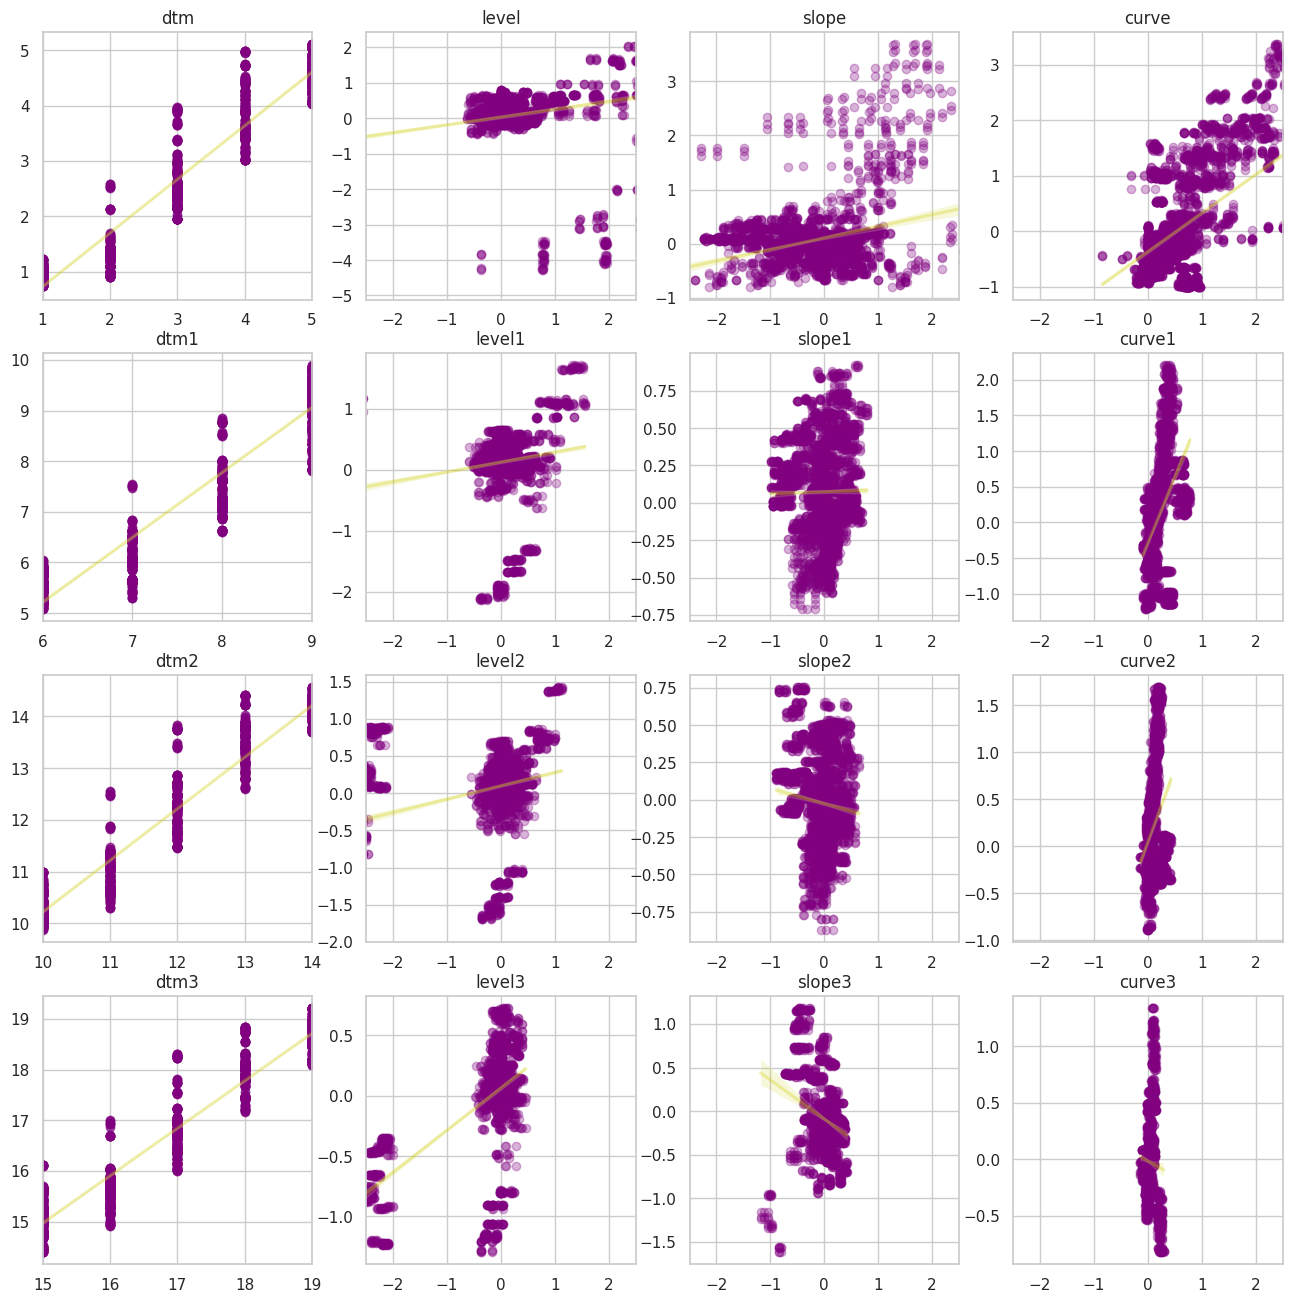

['2023-07-08', '2023-08-19']
duration:  6 (20150, 156) torch.Size([20150, 0]) torch.Size([20150, 22, 6]) torch.Size([20150, 2])
Xcf_dtm, lev 0.5467


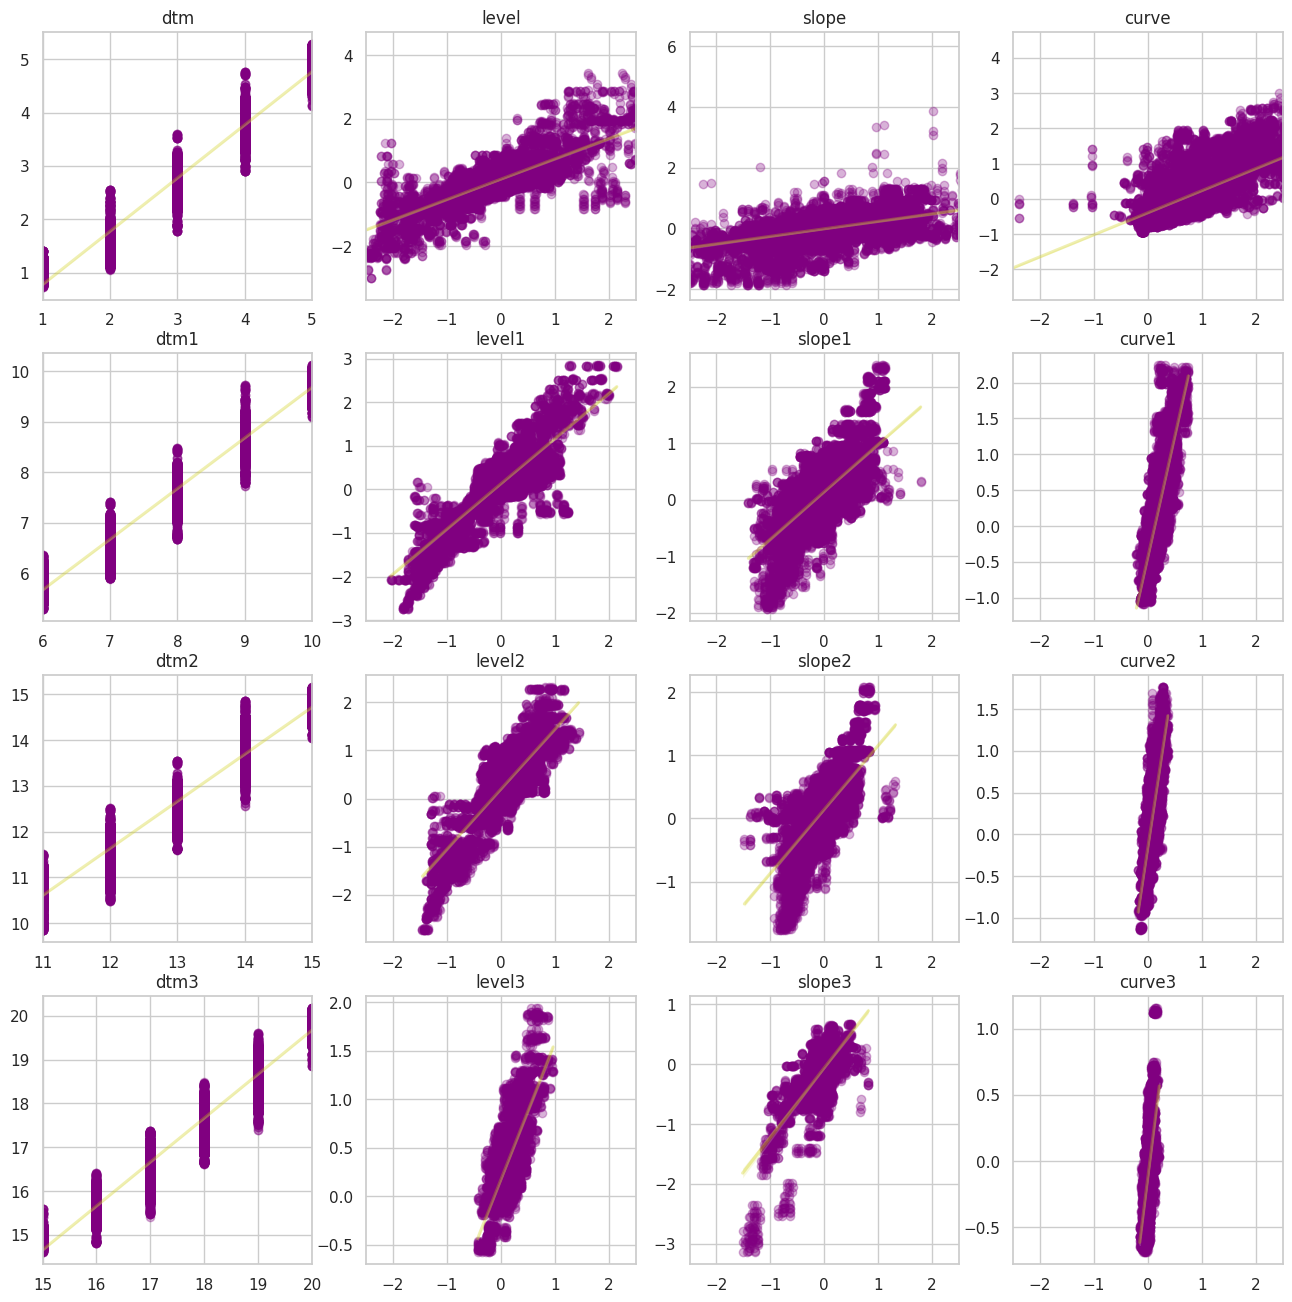

In [ ]:
val_period()

##after

In [ ]:
val_period()

# end

In [ ]:
setup_data(0)

Xcc_close, h torch.Size([65185, 3])
PETrans 5 16 110 [8] 3 0
loaded Xcc_close, h epoch 357
offset  -15178


In [ ]:
y_mean

tensor([ 0.0597,  0.1795, -0.0806], device='cuda:0', dtype=torch.float64)